In [1]:
# data inspection
import pandas as pd
from IPython.display import display

download_dir = './ml-latest-small'
links = pd.read_csv(download_dir + '/links.csv')
display(links.head())
tag = pd.read_csv(download_dir + '/tags.csv')
display(tag.head())
ratings = pd.read_csv(download_dir + '/ratings.csv')
display(ratings.head())
movies = pd.read_csv(download_dir + '/movies.csv')
movies.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
# left join genres onto ratings table
df = ratings.join(movies.set_index('movieId'), on='movieId')
# turn timestamp from seconds to year
change_to_year = lambda x: pd.Timestamp(x, unit='s').year
df.timestamp = df.timestamp.apply(change_to_year)
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


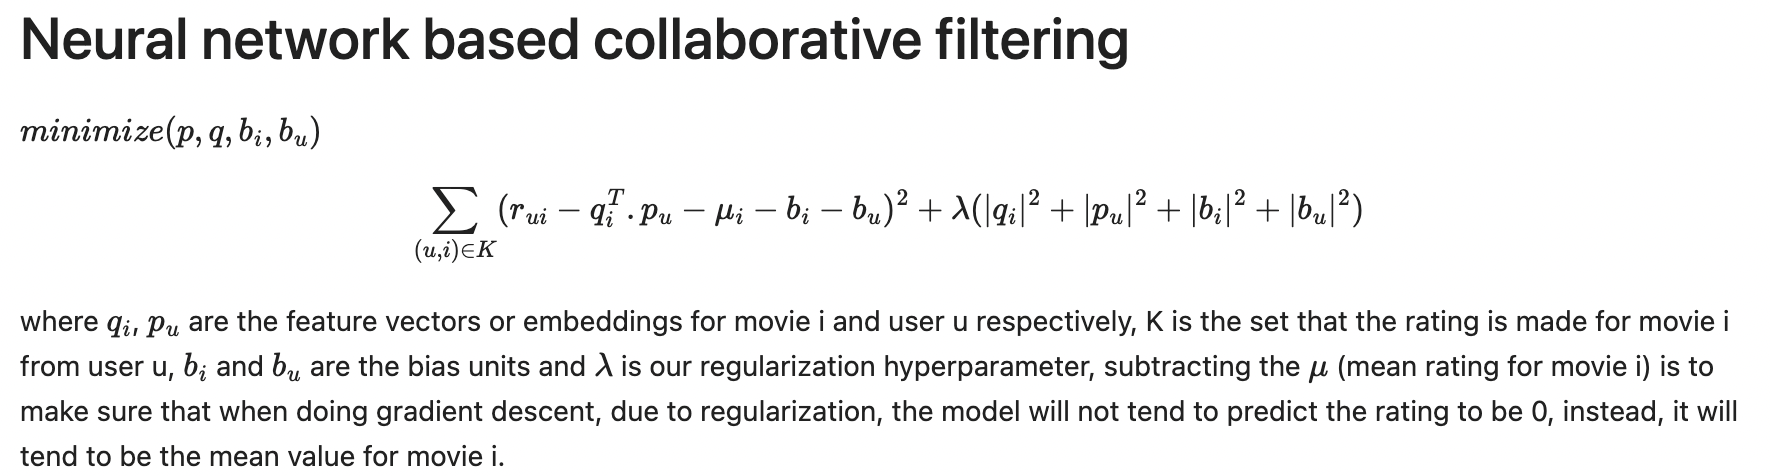

In [3]:
# !pip install torch

In [4]:
import numpy as np
import torch

n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
hidden_d = 100

# prepare the mean rating vector for movies
mu = df.groupby(['movieId'])['rating'].mean()
mu.head()

movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64

In [5]:
# numercially encode movieId, userId and create mapping
movie_map = set(df.movieId.tolist())
movie_map = {movie:i for i, movie in enumerate(movie_map)}

user_map = set(df.userId.tolist())
user_map = {user:i for i, user in enumerate(user_map)}

In [6]:
mu = mu.reset_index()
mu.movieId = mu.movieId.apply(lambda x: movie_map[x])
mu = mu.sort_values(by=['movieId'])
mu = torch.Tensor(mu.rating.tolist())
mu

tensor([3.9209, 3.4318, 3.2596,  ..., 3.0000, 3.9500, 1.5000])

## NeuMF machine

<Axes: >

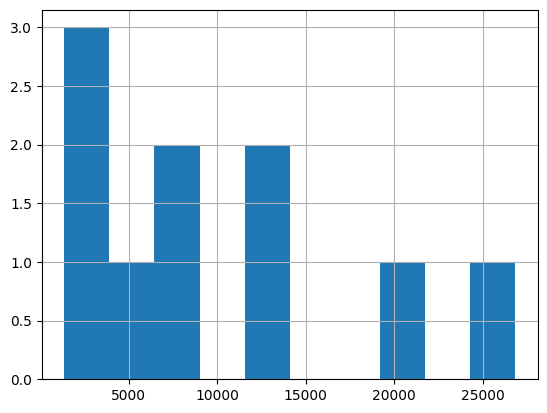

In [7]:
df.rating.value_counts().hist()

In [8]:
# weight function for logloss on skewed classes
weights = df.rating.value_counts(normalize=True).sort_index().tolist()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class NeuMF(nn.Module):
    def __init__(self, n_movies, n_users, n_ratings, hidden_d):
        super(NeuMF, self).__init__()
        # wrapped in nn.parameter, no need to specify requires_grad=True
        self.W1 = nn.Parameter(torch.rand((hidden_d, n_movies)))
        self.W2 = nn.Parameter(torch.rand((hidden_d, n_users)))
        
        self.W3 = nn.Parameter(torch.rand((hidden_d, n_movies)))
        self.W4 = nn.Parameter(torch.rand((hidden_d, n_users)))

        self.MLP1 = nn.Linear(2*hidden_d, hidden_d)
        self.MLP2 = nn.Linear(hidden_d, hidden_d)
        self.MLP3 = nn.Linear(hidden_d, hidden_d)
        
        self.MLP4 = nn.Linear(2*hidden_d, n_ratings)
        
        # hyperparameter as indicated by paper for model ensemble
        self.a = nn.Parameter(torch.tensor(0.5))
                
    def forward(self, x1, x2):
        "x1: n_movies by batch_dimension"
        "x2: n_users by batch_dimension"
        
        x1, x3 = torch.mm(self.W1, x1), torch.mm(self.W3, x1)
        x2, x4 = torch.mm(self.W2, x2), torch.mm(self.W4, x2)
        
        x = x1 * x2
        x = x.t()
        
        x_ = torch.cat((x3, x4), dim=0)
        x_ = x_.t()
        x_ = F.relu(self.MLP1(x_))
        x_ = F.relu(self.MLP2(x_))
        x_ = F.relu(self.MLP3(x_))
        
        x = torch.cat((x * self.a, x_ * (1 - self.a)), dim=1)
        x = F.softmax(self.MLP4(x), dim=1)
        
        "x: batch_dimension by n_ratings"
        return x
    
    # prevent non-convexity issues caused by MSE for classification problems
    def logloss(self, pred, r):
        "r: a batch of numeric ratings"

        loss = torch.tensor(0.)
        count = 0
        
        for i in range(r.size(0)):
            k = int(r[i]/0.5) - 1
            # the use of weight_function can approx. the real logloss over the whole training set 
            loss -= torch.log(pred[i, k])
        
        return loss/r.size(0)

n_ratings = len(df.rating.unique())
Neu_MF = NeuMF(n_movies, n_users, n_ratings, hidden_d)

In [20]:
import torch.optim as optim
optimizer = optim.Adam(Neu_MF.parameters(), lr=0.001)

## Prepare train, test, validation dataset and batch generator

In [21]:
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

from sklearn.model_selection import train_test_split
# 70% train, 21% validation, 9% test
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.3, random_state=41)

In [22]:
# generate tensor for SGD
def batch_generator(X, y, batch_size):
    for i in range(X.shape[0]//batch_size):
        batch_input = X.iloc[i*batch_size: i*batch_size + batch_size]
        batch_output = y.iloc[i*batch_size: i*batch_size + batch_size]
        
        movie_input = []
        user_input = []
        rating_output = []
        
        for _, input_ in batch_input.iterrows():
            user_vector = np.zeros(len(user_map))
            user_vector[user_map[input_.userId]] = 1.
            user_input.append(user_vector)
                    
            movie_vector = np.zeros(len(movie_map))
            movie_vector[movie_map[input_.movieId]] = 1.
            movie_input.append(movie_vector)

        for  output in batch_output:
            rating_output.append(output)
        
        # make sure torch.float for backprop
        movie_input = torch.tensor(movie_input, dtype=torch.float32)
        user_input = torch.tensor(user_input, dtype=torch.float32)
        # for tensor of dimension, n_movies by batch_no
        movie_input = movie_input.t()
        user_input = user_input.t()
        rating_output = torch.tensor(rating_output, dtype=torch.float32)

        yield movie_input, user_input, rating_output

## Monitor validation vs training loss over epochs

In [23]:
sample_size = 5000
X_validation_sample = X_validation.iloc[:sample_size]
y_validation_sample = y_validation.iloc[:sample_size]

X_training_sample = X_train.iloc[:sample_size]
y_training_sample = y_train.iloc[:sample_size]

def loss_check(model, X, y, loss_metric='rmse'):
    with torch.no_grad():
        X_movie, X_user, y_rating = list(batch_generator(X, y, len(X)))[0]
        prediction = model(X_movie, X_user)
        if loss_metric == 'rmse':
            return model.rmseloss(prediction, y_rating).item()
        else:
            return model.logloss(prediction, y_rating).item()

In [26]:
def training_NeuMF(n_epoch):
    # loop over the dataset multiple times
    batch_size = 512
    validation_history = []
    training_history = []
    patience = 5

    for epoch in range(n_epoch):

        running_loss = 0.0
        batch_no = 0
        for movie_input, user_input, rating in batch_generator(X_train, y_train, batch_size):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = Neu_MF(movie_input, user_input)
            loss = Neu_MF.logloss(outputs, rating)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if batch_no % 30 == 29:
                print('[{}, {}] average_loss per batch: {}'.format(epoch+1, batch_no+1, running_loss/30))
                running_loss = 0.0

            batch_no += 1

        # check training and validation loss after every epoch
        training_loss = loss_check(Neu_MF, X_training_sample, y_training_sample, loss_metric='logloss')
        print('training_loss: {}'.format(training_loss))
        training_history.append(training_loss)
        
        vali_loss = loss_check(Neu_MF, X_validation_sample, y_validation_sample, loss_metric='logloss')
        print('validation_loss: {}'.format(vali_loss))
        validation_history.append(vali_loss)
        
        if len(validation_history) >= patience:
            # either validation_loss doesnt improve or model starts to overfit
            if abs(validation_history[-1] - validation_history[-patience]) / validation_history[-patience] < 0.001\
                                                        or validation_history[-1] > validation_history[-patience]:
                print('Early stopping')
                break

    print('Finished Training')
    return validation_history, training_history

n_epoch = 3
validation_history, training_history = training_NeuMF(n_epoch)

[1, 30] average_loss per batch: 2.3252859512964883
[1, 60] average_loss per batch: 2.324900237719218
[1, 90] average_loss per batch: 2.3239533106486
[1, 120] average_loss per batch: 2.3252063512802126
training_loss: 2.326767921447754
validation_loss: 2.324303150177002
[2, 30] average_loss per batch: 2.3252859512964883
[2, 60] average_loss per batch: 2.324900237719218
[2, 90] average_loss per batch: 2.3239533106486
[2, 120] average_loss per batch: 2.3252063512802126
training_loss: 2.326767921447754
validation_loss: 2.324303150177002
[3, 30] average_loss per batch: 2.3252859512964883
[3, 60] average_loss per batch: 2.324900237719218
[3, 90] average_loss per batch: 2.3239533106486
[3, 120] average_loss per batch: 2.3252063512802126
training_loss: 2.326767921447754
validation_loss: 2.324303150177002
Finished Training


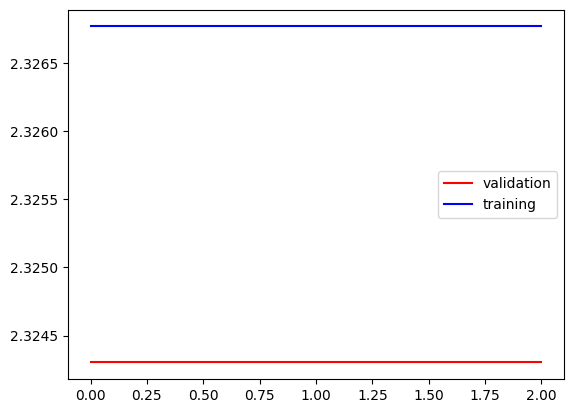

In [27]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(validation_history)), validation_history, color='r', label='validation')
plt.plot(np.arange(len(training_history)), training_history, color='b', label='training')
plt.legend()
plt.show()

## Predictions for test data by MFnn

In [28]:
test_loss = loss_check(Neu_MF, X_test, y_test, loss_metric='logloss')
print('test logloss: {}'.format(test_loss))

# demo compared to ground truth
with torch.no_grad():
    X_sample, y_sample = X_test[:1000], y_test[:1000]
    sample_movie, sample_user, rating_truth = list(batch_generator(X_sample, y_sample, len(X_sample)))[0]
    prediction = Neu_MF(sample_movie, sample_user).numpy()
    prediction = (np.argmax(prediction, axis=1) + 1) * 0.5
    rmse = np.mean((prediction - rating_truth.numpy())**2)**0.5
    print('rmse of prediction against ground truth: {}'.format(rmse))

test logloss: 2.3250792026519775
rmse of prediction against ground truth: 2.76762533591525


In [ ]:
# Ref: https://github.com/neoyung/recommender-system/blob/master/Neural%20network%20based%20collaborative%20filtering.ipynb